# Malerei: Transferencia de Estilo Avanzado

Parametros

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#settings
#resolucion de entrada default 512 (cuanto mayor mas va a tardar)
maxima_dimension_imagen = 512 #@param {type:"number"}
#total loss: 1 si tomo, 0 si no 
considero_total_loss = 1 #@param ["1", "0"] {type:"raw"}
#optimizador--> ADAM 2--> LBFGS --> por ahora no usarlo
optimizador = 1 #@param ["1", "0"] {type:"raw"}
learning_rate_adam = 0.02 #@param {type:"slider", min:0.01, max:0.1, step:0.01}
beta_1_adam = 0.99 #@param {type:"slider", min:0.1, max:0.99, step:0.01}
epsilon_adam = 1e-1 #@param #default 1e-1

style_weight_value = 1e-2 #@param #default 1e-2
content_weight_value = 1e4 #@param #default 1e4

epochs_value_1 = 11 #@param {type:"slider", min:5, max:100, step:1}
steps_per_epoch_value_1 = 100 #@param {type:"slider", min:25, max:200, step:10}

file_name_value_1 = 'stylized-image1-' #@param #default 'stylized-image-'

#considerarlo si considero_total_loss = 1
total_variation_weight_value = 30 #@param #default 30
epochs_value_2 = 25 #@param {type:"slider", min:5, max:100, step:1}
steps_per_epoch_value_2 = 100 #@param {type:"slider", min:25, max:200, step:10}
file_name_value_2 = 'stylized-image2-' #@param #default 'stylized-image2-'



In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

from google.colab import drive
from google.colab import files

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


In [ ]:
print("SELECCIONAR UNA DE CADA UNA!!")
print("SELECCIONAR IMAGENES CONTENIDO")
content_image = files.upload()

print("SELECCIONAR IMAGENES ESTILO")
style_image = files.upload()

contenidos = list(content_image.keys())
estilos = list(style_image.keys())



SELECCIONAR UNA DE CADA UNA!!
SELECCIONAR IMAGENES CONTENIDO


SELECCIONAR IMAGENES ESTILO


KeyboardInterrupt: ignored

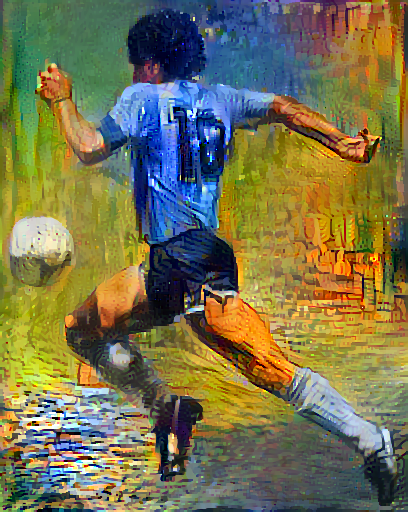

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train step: 5000
Total time: 404.6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

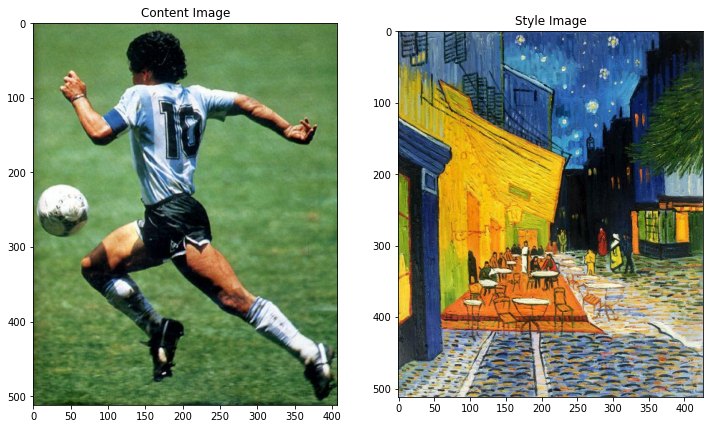

In [ ]:
def load_img(path_to_img):
  max_dim = maxima_dimension_imagen #512  #JUEGO CON LA RESOLUCION DE ENTRADA ACA --> PONER UN SLICER DE PARAMETRO!!! CON MAGENTA CAMBIA MUCHO LA IMAGEN DE RESULTADO QUE TE TRAE EN FUNCION DE LA RESOLUCION
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

content_image = load_img(contenidos[0]) #modificacion by mua
style_image = load_img(estilos[0])

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
#prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
#[(class_name, prob) for (number, class_name, prob) in predicted_top_5] #se podria comentar creo

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

#print() #se podria comentar --> te imprime todas las redes utilizadas
#for layer in vgg.layers: 
#  print(layer.name)

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
#for name, output in zip(style_layers, style_outputs):
 # print(name)
  #print("  shape: ", output.numpy().shape)
  #print("  min: ", output.numpy().min())
  #print("  max: ", output.numpy().max())
  #print("  mean: ", output.numpy().mean())
  #print()

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

'''
print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

'''

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


opt = tf.optimizers.Adam(learning_rate = learning_rate_adam, beta_1 = beta_1_adam, epsilon = epsilon_adam)
 
style_weight = style_weight_value
content_weight = content_weight_value

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

if considero_total_loss == 0:

  import time
  start = time.time()

  epochs = epochs_value_1
  steps_per_epoch = steps_per_epoch_value_1

  display.display(tensor_to_image(image)) #para que muestre como arranca

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image)
      print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
    file_name = file_name_value_1  + str(n) + '.png'
    tensor_to_image(image).save(file_name) #comentar
    files.download(file_name) #comentar si no quiero guardar cada imagen
    
  end = time.time()
  print("Total time: {:.1f}".format(end-start))

   #///////////////////////////////////////////////////////////////#

elif considero_total_loss == 1:

  def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_var, y_var

  x_deltas, y_deltas = high_pass_x_y(content_image)

  #plt.figure(figsize=(14, 10))
  #plt.subplot(2, 2, 1)
  #imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

  #plt.subplot(2, 2, 2)
  #imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

  x_deltas, y_deltas = high_pass_x_y(image)

  #plt.subplot(2, 2, 3)
  #imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

  #plt.subplot(2, 2, 4)
  #imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

  #plt.figure(figsize=(14, 10))

  sobel = tf.image.sobel_edges(content_image)
  #plt.subplot(1, 2, 1)
  #imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
  #plt.subplot(1, 2, 2)
  #imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

  def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

  total_variation_loss(image).numpy()
  tf.image.total_variation(image).numpy()

  total_variation_weight =  total_variation_weight_value


  @tf.function()
  def train_step(image):
    with tf.GradientTape() as tape:
      outputs = extractor(image)
      loss = style_content_loss(outputs)
      loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

  image = tf.Variable(content_image)

  import time
  start = time.time()

  epochs = epochs_value_2
  steps_per_epoch = steps_per_epoch_value_2

  display.display(tensor_to_image(image)) #para que muestre como arranca

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image)
      print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    file_name = file_name_value_2 + str(n) + '.png'
    tensor_to_image(image).save(file_name)
    files.download(file_name)

    print("Train step: {}".format(step))

  end = time.time()
  print("Total time: {:.1f}".format(end-start))

  file_name = 'stylized-image-final.png'
  tensor_to_image(image).save(file_name)

  try:
    from google.colab import files
  except ImportError:
    pass
  else:
    files.download(file_name)



### Codigo para guardar imagen

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## MAGENTA --> EL CODIGO DE TRANSFERENCIA QUE YA USAMOS (4)

In [ ]:
#MAGENTA
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)


file_name = 'stylized-image.png'
tensor_to_image(stylized_image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)